# Calculation of catenary

In [190]:
# itegrate funkcija clasa koja nije klasa
from math import cos,sin,tan,atan,degrees,radians, pi
import numpy as np
from scipy.integrate import quad
# funkcije oblika
def integrand_n1(x,l):
    return 1- (3*x**2/ l**2) + (2*x**3/l**3)

def integrand_n2(x,l):
    return (-x) + (2 * x ** 2 / l) - (x ** 3 / l ** 2)

def integrand_n3(x,l):
    return (3 * x ** 2 / l ** 2) - (2 * x ** 3 / l ** 3)

def integrand_n4(x,l):
    return (x ** 2 / l) - (x ** 3 / l ** 2)

def integrand_n11(x,l):
    return 1 - (x / l)

def integrand_n22(x,l):
    return x/l

In [11]:
# Input data
#lenght of one element(pipe)
l_pipe = 2000
l = 5
points = np.array([[344.729,2.891,17.845],[451.9433,943.8932,-1363.0841]])
#parametars
E = 210*1000000000 # N/m^2 modul elastičnosti
rhoWater = 1025 # kg/ m^3
outerDiameter = 0.38094 # m outer diameter of pipe
innerDiameter = 0.1778 # m inner diameter of pipe
sea_depth = 1365 # m
#moment tromosti za cijev ovih dimenzija
I = pi/4*(outerDiameter**4-innerDiameter**4)
#gravity acc
g = 9.81 # m/s^2
#površina poprečnog  presjeka cijevi
A_pipe = ((outerDiameter**2 * pi) /4) - ((innerDiameter**2 * pi) / 4)

#sile koje djeluju na cijev
weight_in_air = 161.34 # kg/m
Volume_pipe = (outerDiameter)**2 *pi /4 # Volume per meter  m^3 /m
buoyancy = rhoWater * Volume_pipe  # kg /m
weight_in_water = weight_in_air - buoyancy  #kg /m
print(f"End A = {points[0]}m, End B={points[1]}m")
print(f"weight in water of given pipe with od={outerDiameter*1000}mm and wt {(outerDiameter-innerDiameter)/2*1000}mm is {weight_in_water}kg/m")
# gravity force
G_f = -weight_in_water * g # N/m

End A = [344.729   2.891  17.845]m, End B=[  451.9433   943.8932 -1363.0841]m
weight in water of given pipe with od=380.94mm and wt 101.57mm is 44.51739084915165kg/m


In [13]:



# A_node = np.array([344.729,2.891,17.845])   # point of node A
# B_node = np.array([451.9433,943.8932,-1363.0841])   # point of node B
#
#
# L = B_node[0]- A_node[0]
# H = B_node[1]- A_node[1]


L = points[1][0]- points[0][0]
H = points[1][1]- points[0][1]
alfa = atan(H/L)  # Azimuth angle

print(f"Azimuth is {degrees(alfa)} deg")
t_m = np.array([[cos(alfa), sin(alfa),0],[-sin(alfa), cos(alfa), 0],[0,0,1]])
new_points =[]
for vect in points:
  new_points.append(t_m.dot(vect))

print(f"Rotating coordinate system around azimuth has \nEnd A={new_points[0]},End B={new_points[1]}")


#transforming pipe into local x_z, making z constant

L1 = new_points[1][0] -new_points[0][0]
H1 = new_points[0][2]- new_points[1][2]
alfa1 = atan(H1/L1)
alfa1= -alfa1




T = np.array([[cos(alfa1), sin(alfa1), 0, 0, 0, 0], [-sin(alfa1), cos(alfa1), 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],
                [0, 0, 0, cos(alfa1), sin(alfa1), 0], [0, 0, 0, -sin(alfa1), cos(alfa1), 0], [0, 0, 0, 0, 0, 1]])  # matix of transfrmation

# matrix of stiffness
k_local = np.array([[(A_pipe* E / l), 0, 0, (-A_pipe*E/ l), 0, 0], [0, 12*(E*I)/l**3, -6*(E*I)/l**2, 0, -12*(E*I)/l**3, -6*(E*I)/l**2],
             [0, -6*(E*I)/l**2 , 4*(E*I)/l, 0, 6*(E*I)/l**2, 2*(E*I)/l], [(-A_pipe* E / l), 0, 0, (A_pipe*E/ l), 0, 0],
             [0, -12*(E*I)/l**3, 6*(E*I)/l**2, 0, 12*(E*I)/l**3, 6*(E*I)/l**2], [0, -6*(E*I)/l**2 , 2*(E*I)/l, 0, 6*(E*I)/l**2, 4*(E*I)/l]] )

# lokalna matrica krutosti u odnosu na globalnu
T_transpose = T.transpose()  # transpose matrix of transformation
k_glo = np.matmul(T_transpose,k_local)
k_global = np.matmul(k_glo, T)


#proširivanje na globalnu razinu za svaki konačni element
elements = int(l_pipe/5)
K =np.zeros((elements*3 + 3,elements*3 + 3))
for x in range(elements):
    for y in range(6):
        count = 0
        for k in k_global[y]:
            K[y+3*x][count+ 3*x] += k
            count += 1

# print(G_f)
# prebacivanje u lokalni sustav
G_f_x = -G_f* sin(-alfa1)
G_f_z= G_f* cos(-alfa1)

# Funkcije oblika za cjevovod

# N1 = quad(integrand_n1, f , x, args=l)
# N2 = quad(integrand_n2, f, x, args=l)
# N3 = quad(integrand_n3, f, x, args=l)
# N4 = quad(integrand_n1, f, x, args=l)
# N11 = quad(integrand_n11, f, x, args=l)
# N22= quad(integrand_n22, f, x, args=l)
# # N = np.array([[N11[0], 0], [0, N1[0]], [0, N2[0]], [N22[0], 0], [0, N3[0]], [0, N4[0]]])

# definiranje svih sila koje djeluju na gredu
R = np.zeros((elements*3 +3,1))
f = 0
for e in range(elements):

    x = f+ 5

    N1 = quad(integrand_n1, f, x, args=l_pipe)
    N2 = quad(integrand_n2, f, x, args=l_pipe)
    N3 = quad(integrand_n3, f, x, args=l_pipe)
    N4 = quad(integrand_n1, f, x, args=l_pipe)
    N11 = quad(integrand_n11, f, x, args=l_pipe)
    N22 = quad(integrand_n22, f, x, args=l_pipe)
    N = np.array([[N11[0], 0], [0, N1[0]], [0, N2[0]], [N22[0], 0], [0, N3[0]], [0, N4[0]]])
    # kontinuirana opterećenja
    Q = np.array([[G_f_x], [G_f_z]])
    # konačne sile i momenti u lokalnom sustavu
    F = np.matmul(N, Q)
    # u lokalnom sustavu  u odnosu na globalni
    F = np.matmul(T_transpose,F)

    f += 5
    for y in range(6):
        R[y+ 3*e][0] += F[y][0]


print(R)
K_inv = np.linalg.pinv(K)


# # pomaci u svim čvorovima
v= np.matmul(K_inv, R)

######
# D = np.array([[A_pipe*E, 0], [0, E*I]])
# B = np.array([[-1/l, 0, 0, 1/l, 0, 0], [0, (6/l**2)-(12*l/l**3), (-4/l) + (6*l/l**2), 0, (-6/l**2)+(12*l/l**3), (-2/l) + (6*l/l**2)]])
# DB =  np.matmul(D, B)
#
# # sila i moment na cijevi
# sigma = np.matmul(DB, v)
#



Azimuth is 83.49996141503874 deg
Rotating coordinate system around azimuth has 
End A=[  41.89707735 -342.18573353   17.845     ],End B=[  988.98738273  -342.18573353 -1363.0841    ]
[[-1.26677004e+00]
 [-2.18171734e+03]
 [ 3.07727739e+03]
 ...
 [-1.26677004e+00]
 [-2.18171734e+03]
 [-7.70925040e-03]]


In [17]:
R.shape

(1203, 1)

In [19]:
v.shape

(1203, 1)

In [22]:
F

array([[ 1.26677004e+00],
       [-1.86067657e+00],
       [ 5.13628406e+00],
       [-1.26677004e+00],
       [-2.18171734e+03],
       [-7.70925040e-03]])

In [60]:
import pandas as pd
# df=pd.DataFrame()
x= [v[i] for i in range(0, len(v), 3)]
y= [v[i] for i in range(1, len(v), 3)]
z= [v[i] for i in range(2, len(v), 3)]
df=pd.DataFrame(x)
df.columns=["x"]
df["y"]=pd.DataFrame(y)
df["z"]=pd.DataFrame(z)
# df=pd.DataFrame(x)
# df.columns=["x","y","z"]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.scatterplot(x=df.index, y="x", data=df)
sns.scatterplot(x=df.index, y="y", data=df)
sns.scatterplot(x=df.index, y="z", data=df)

## Verzija 27-2-2020

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
from math import cos,sin,tan,atan,degrees,radians, pi
import numpy as np
from scipy.integrate import quad
# funkcije oblika
def integrand_n1(x,l):
    return 1- (3*x**2/ l**2) + (2*x**3/l**3)

def integrand_n2(x,l):
    return (-x) + (2 * x ** 2 / l) - (x ** 3 / l ** 2)

def integrand_n3(x,l):
    return (3 * x ** 2 / l ** 2) - (2 * x ** 3 / l ** 3)

def integrand_n4(x,l):
    return (x ** 2 / l) - (x ** 3 / l ** 2)

def integrand_n11(x,l):
    return 1 - (x / l)

def integrand_n22(x,l):
    return x/l

#parametars
E = 210*1000000000 # N/m^2 modul elastičnosti
rhoWater = 1025 # kg/ m^3
outerDiameter = 0.38094 # m outer diameter of pipe
innerDiameter = 0.1778 # m inner diameter of pipe
sea_depth = 1365 # m
#moment tromosti za cijev ovih dimenzija
I = pi/4*(outerDiameter**4-innerDiameter**4)
# bending_stiffness = 176820
# E = bending_stiffness/I
print(E)
#gravity acc
g = 9.81 # m/s^2
#površina poprečnog  presjeka cijevi
A_pipe = ((outerDiameter**2 * pi) /4)- ((innerDiameter**2 * pi) / 4)

m = A_pipe*7800


#sile koje djeluju na cijev
weight_in_air = 161.34 # kg/m

density = weight_in_air/A_pipe
print(f"density is {density} kg/m3")
Volume_pipe = (outerDiameter)**2 *pi /4 # Volume per meter  m^3 /m
buoyancy = rhoWater * Volume_pipe  # kg /m
weight_in_water = weight_in_air - buoyancy  #kg /m

# gravity force
G_f = weight_in_water * g # N/m



# A_node = np.array([344.729,2.891,17.845])   # point of node A
# B_node = np.array([451.9433,943.8932,-1363.0841])   # point of node B
#
#
# L = B_node[0]- A_node[0]
# H = B_node[1]- A_node[1]

#lenght of one element(pipe)
l_pipe = 1675
l = 5




points = np.array([[0,0,0],[947.090293,0,-1380.929111]])
L = points[1][0]- points[0][0]
H = points[1][1]- points[0][1] ## ovo nije H
alfa = atan(H/L)  # Azimuth angle

print(f"Azimuth is {degrees(alfa)} deg")
t_m = np.array([[cos(alfa), sin(alfa),0],[-sin(alfa), cos(alfa), 0],[0,0,1]])
new_points =[]
for vect in points:
  new_points.append(t_m.dot(vect))




#transforming pipe into local x_z, making z constant

L1 = new_points[1][0] -new_points[0][0]
H1 = new_points[0][2]- new_points[1][2]
alfa1 = atan(H1/L1)
# alfa1= -alfa1
print(f"Initial L={L1}, H={H1}, and departure angle max = {degrees(alfa1)}")

t_m_2 = np.array([[cos(alfa1), sin(alfa1)],[-sin(alfa1), cos(alfa1)]])


T = np.array([[cos(alfa1), sin(alfa1), 0, 0, 0, 0], [-sin(alfa1), cos(alfa1), 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],
                [0, 0, 0, cos(alfa1), sin(alfa1), 0], [0, 0, 0, -sin(alfa1), cos(alfa1), 0], [0, 0, 0, 0, 0, 1]])  # matix of transfrmation

# matrix of stiffness
k_local = np.array([[(A_pipe* E / l), 0, 0, (-A_pipe*E/ l), 0, 0], [0, 12*(E*I)/l**3, -6*(E*I)/l**2, 0, -12*(E*I)/l**3, -6*(E*I)/l**2],
             [0, -6*(E*I)/l**2 , 4*(E*I)/l, 0, 6*(E*I)/l**2, 2*(E*I)/l], [(-A_pipe* E / l), 0, 0, (A_pipe*E/ l), 0, 0],
             [0, -12*(E*I)/l**3, 6*(E*I)/l**2, 0, 12*(E*I)/l**3, 6*(E*I)/l**2], [0, -6*(E*I)/l**2 , 2*(E*I)/l, 0, 6*(E*I)/l**2, 4*(E*I)/l]] )

# lokalna matrica krutosti u odnosu na globalnu
T_transpose = T.transpose()  # transpose matrix of transformation
k_glo = np.matmul(T_transpose,k_local)
k_global = np.matmul(k_glo, T)


#proširivanje na globalnu razinu za svaki konačni element
elements = int(l_pipe/5)
K =np.zeros((elements*3 + 3,elements*3 + 3))
for x in range(elements):
    for y in range(6):
        count = 0
        for k in k_global[y]:
            K[y+3*x][count+ 3*x] += k
            count += 1


# prebacivanje u lokalni sustav
G_f_x = -G_f* cos(pi-alfa1)
G_f_z= -G_f* sin(pi-alfa1)

print(f"Gravity force {G_f}N in local coordinate system rotated around Y by {degrees(alfa1)}\n\
has components x={G_f_x}N,z={G_f_z}N")




# Funkcije oblika za cjevovod

# N1 = quad(integrand_n1, f , x, args=l)
# N2 = quad(integrand_n2, f, x, args=l)
# N3 = quad(integrand_n3, f, x, args=l)
# N4 = quad(integrand_n1, f, x, args=l)
# N11 = quad(integrand_n11, f, x, args=l)
# N22= quad(integrand_n22, f, x, args=l)
# # N = np.array([[N11[0], 0], [0, N1[0]], [0, N2[0]], [N22[0], 0], [0, N3[0]], [0, N4[0]]])


# definiranje svih sila koje djeluju na gredu
R = np.zeros((elements*3 +3,1))
f = 0
for e in range(elements):

    f= 0
    x= 5

    N1 = quad(integrand_n1, f, x, args=l)
    N2 = quad(integrand_n2, f, x, args=l)
    N3 = quad(integrand_n3, f, x, args=l)
    N4 = quad(integrand_n1, f, x, args=l)
    N11 = quad(integrand_n11, f, x, args=l)
    N22 = quad(integrand_n22, f, x, args=l)
    N = np.array([[N11[0], 0], [0, N1[0]], [0, N2[0]], [N22[0], 0], [0, N3[0]], [0, N4[0]]])

    # kontinuirana opterećenja
    Q = np.array([[G_f_x], [G_f_z]])
    # konačne sile i momenti u lokalnom sustavu
    F = np.matmul(N, Q)
    # u lokalnom sustavu  u odnosu na globalni
    F = np.matmul(T_transpose,F)


    for y in range(6):
        R[y+ 3*e][0] += F[y][0]


K =  np.delete(K,0, axis=0)
K =  np.delete(K,0, axis=0)
K =  np.delete(K,-1, axis=0)
K =  np.delete(K,-1, axis=0)
K =  np.delete(K,-1, axis=0)
# K =  np.delete(K,0, axis=0)
K =  np.delete(K,0, axis=1)
K =  np.delete(K,0, axis=1)
K =  np.delete(K,-1, axis=1)
K =  np.delete(K,-1, axis=1)
K =  np.delete(K,-1, axis=1)

R = np.delete(R,0, axis=0)
R = np.delete(R,0, axis=0)
R = np.delete(R,-1, axis=0)
R = np.delete(R,-1, axis=0)
R = np.delete(R,-1, axis=0)

R[0][0]= 0   # postavljamo moment u nulu


K_inv = np.linalg.inv(K)



# # pomaci u svim čvorovima pomak x, z i kut zakreta oko osi y
v= np.matmul(K_inv, R)

v= np.insert(v, 0, 0, axis=0)
v= np.insert(v, 0, 0, axis=0)
v= np.append(v, [[0], [0], [0]],  axis=0)


# place = 4
# count = 1
# for x in v:
#
#     if place-count == 3:
#         x[0] += 8.98
#     elif place - count == 2:
#         x[0] += 44.644
#     if count == place:
#         place +=3
#     count += 1

place = 4
count = 1

point = np.zeros((2,1))

new_v = []
for x in v:
    list_point_x = []
    list_point_y = []
    if place-count == 3:

        point[0] = x[0]
    elif place - count ==2:
        point[1] = x[0]
    if count == place:
        place += 3
        new_point =np.matmul(t_m_2,point)

        list_point_x.append(float(new_point[0]))
        list_point_y.append(float(new_point[1]))

        new_v.append(list_point_x)
        new_v.append(list_point_y)

    count += 1

v2 = np.asarray(new_v)



####
# D = np.array([[A_pipe*E, 0], [0, E*I]])
# B = np.array([[-1/l, 0, 0, 1/l, 0, 0], [0, (6/l**2)-(12*l/l**3), (-4/l) + (6*l/l**2), 0, (-6/l**2)+(12*l/l**3), (-2/l) + (6*l/l**2)]])
# DB =  np.matmul(D, B)
#
# # sila i moment na cijevi
# sigma = np.matmul(DB, v)
##
#

count = 0
to_new_node = 0
for x in v2:
    if (count % 2) == 0:
        x[0] += 8.98 + to_new_node
        to_new_node += 5
    else:
        x[0] += 44.644

    count += 1


x_z = []
point = np.zeros((2, 1))
t_m_2_t = t_m_2.transpose()
count = 2
list_point_x = []
list_point_y = []
for x in v2:

    if (count % 2) == 0:
        point[0] = x[0]

    else:
        point[1] = x[0]
        new_point = np.matmul(t_m_2_t, point)
        list_point_x = []
        list_point_y = []
        list_point_x.append(float(new_point[0]))
        list_point_y.append(float(new_point[1]))
        x_z.append(list_point_x)
        x_z.append(list_point_y)


    count += 1



# koordinate u x_z osi savijene cijevi


# prvi član je x drugi y i tako dalje

x_z = np.asarray(x_z)
# print(x_z)

210000000000
density is 1809.8682427624065 kg/m3
Azimuth is 0.0 deg
Initial L=947.090293, H=1380.929111, and departure angle max = 55.55628466064411
Gravity force 436.71560423017775N in local coordinate system rotated around Y by 55.55628466064411
has components x=247.00476537349164N,z=-360.1515859480777N


In [105]:
v

array([[ 0.        ],
       [ 0.        ],
       [10.65773654],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

NameError: name 'show' is not defined

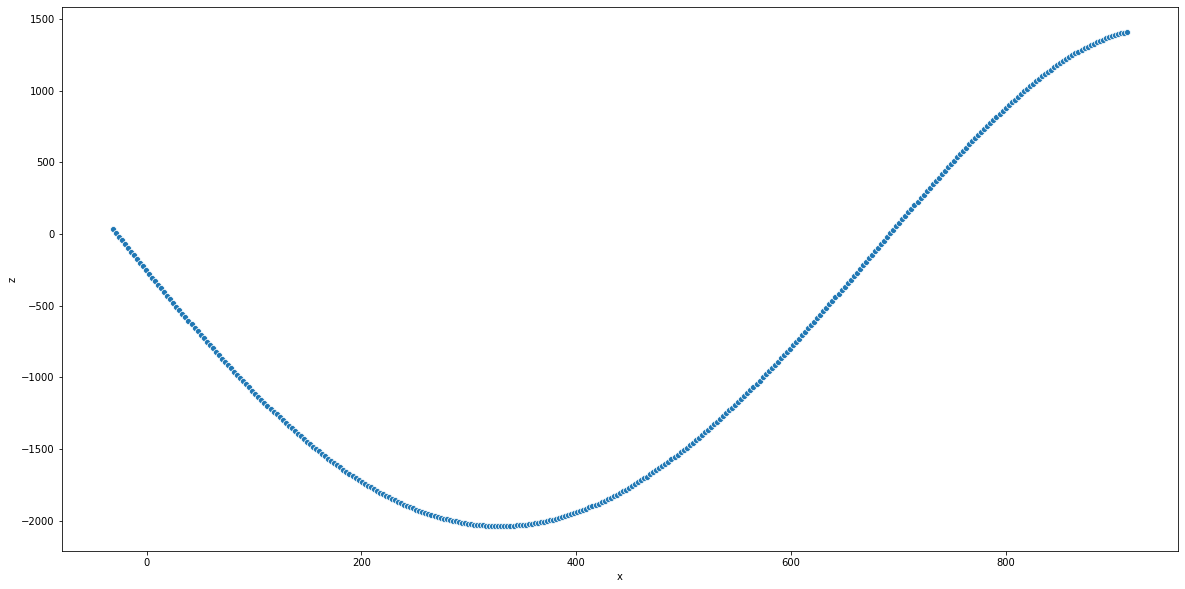

In [107]:

x= [x_z[i] for i in range(0, len(x_z), 2)]
z= [x_z[i] for i in range(1, len(x_z), 2)]
df=pd.DataFrame(x)
df.columns=["x"]
df["z"]=pd.DataFrame(z)
plt.figure(figsize=(20,10))
plot = sns.scatterplot(x="x", y="z", data=df)


In [96]:
df

,x,z
0,-31.738057,32.656131
1,-28.910075,66.918580
2,-26.082093,101.176220
3,-23.254111,135.424276
4,-20.426129,169.658008
...,...,...
330,901.495972,1399.962458
331,904.323954,1401.738037
332,907.151936,1404.021521
333,909.979918,1406.820832


In [79]:
atan(0)

0.0

Starting script for suspended line pipe calculator!
Starting calculation with following parameters:
H = 1481.0042
L = 1541.2761
alpha = 6
line_weight = 47.803
bending_stiffness = 1760820.0
y_bottom is = 165.403793
T_0 is = 694.51kN
Bottom tension at node 29 x=1935.7m, Arc length=2619.31m is 149.19 kN
165.403793 -124.634252 414 843
Rate of convergance is: 5.445041100199464
y_bottom is = -124.634252
T_0 is = 847.26kN
Bottom tension at node 15 x=351.5m, Arc length=1611.88m is 176.71 kN
Runing iteration number 1000...
-124.634252 23.000043 843 1244
Rate of convergance is: 14.521723765213283
y_bottom is = 23.000043
T_0 is = 770.88kN
Bottom tension at node 29 x=1824.2m, Arc length=2720.05m is 132.45 kN
23.000043 -50.016677 1244 1647
Rate of convergance is: -3.8410399624060627
y_bottom is = -50.016677
T_0 is = 809.07kN
Bottom tension at node 15 x=381.8m, Arc length=1611.88m is 152.15 kN
Runing iteration number 2000...
-50.016677 -16.18083 1647 2035
Rate of convergance is: 4.996523786985536
y_

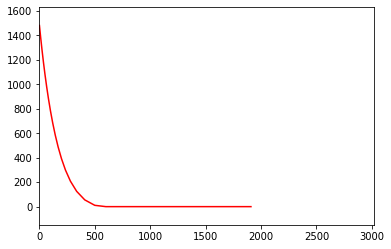

In [187]:
# Python script to calculate pipe line length
# Version: 1.0
# Author: Andres Belles Meseguer
# Date: 27 February 2020

#####################################################################
# Prerequisites:
#####################################################################
# - Python installed
# - Matplotlib library installed for plots
#   (python -m pip install -U pip
#    python -m pip install -U matplotlib

import math
import matplotlib
import matplotlib.pyplot as plt
import time;

print('Starting script for suspended line pipe calculator!')
#####################################################################
# Instructions:
#####################################################################
# - Define parameters
# - Run script


#####################################################################
# Parameters
#####################################################################


H=1481.0042 #H = dubina (apsolutna vrednost z koordinate poslednje tacke).  
L=1541.2761 #L = udaljenost izmedju prve i poslednje tacke.  
alpha=6 # departure angle parametar za flexible riser rule.
bending_stiffness = 1760.82e3 #property
line_weight=47.803 # property weight
T_0=694513.2 #line_weight*H*9.81
segments=30 #(L+H)/10
damp=0 # dampning of the iteration. In case the solution does not converge use higer number 0 to 3 recommended. 

"""
H = 1380.929  # m
L = 947.090  # m
alpha = 6.5  # deg
bending_stiffness = 1760.82e3  # Nm2
line_weight = 44.517  # kg/m
T_0 = 700.0e3  # N to start iterating
segments = 100
"""
#####################################################################
# Calculation
#####################################################################
print('Starting calculation with following parameters:')
print('H = ' + str(H))
print('L = ' + str(L))
print('alpha = ' + str(alpha))
print('line_weight = ' + str(line_weight))
print('bending_stiffness = ' + str(bending_stiffness))

# An iterative process is necessary:
# L is divided in L_air and L_contact

boundary = 3

s = (H + L) / segments

x = [0] * (segments + 1)
y = [0] * (segments + 1)
w = [line_weight * 9.81] * (segments)
theta = [0] * (segments + boundary * 2)
T = [T_0] * (segments)

theta = [0] * (segments + boundary * 2)
T = [T_0] * (segments)

# Boundary conditions
x[0] = 0.0
x[segments] = L
y[0] = H
y[segments] = 0.0

for i in range(0, boundary):
    theta[i] = math.radians(90.0 - alpha)

# Initialization

for i in range(1, segments + 1):
    x[i] = x[i - 1] + s * math.cos(theta[boundary + i - 1])
    y[i] = y[i - 1] - s * math.sin(theta[boundary + i - 1])
    x[i] = round(x[i], 6)
    y[i] = round(y[i], 6)


def Initialization():
    theta = [0] * (segments + boundary * 2)
    T = [T_0] * (segments)

    # Boundary conditions
    x[0] = 0.0
    x[segments] = L
    y[0] = H
    y[segments] = 0.0

    for i in range(0, boundary):
        theta[i] = math.radians(90.0 - alpha)

    # Initialization

    for i in range(1, segments + 1):
        x[i] = x[i - 1] + s * math.cos(theta[boundary + i - 1])
        y[i] = y[i - 1] - s * math.sin(theta[boundary + i - 1])
        x[i] = round(x[i], 6)
        y[i] = round(y[i], 6)


# Initialization()

contact_point = 0.0
total_length_at_L = 0.0
old_total_length = 0.0


def ShowPlot(print_results=1):
    if (print_results == 1):
#         print('x = ' + str(x))
#         print('y = ' + str(y))
#         print('s = ' + str(s))
#         print('theta = ' + str(theta))
#         print('w = ' + str(w))
#         print('T = ' + str(T))
        print('total_length_at_L = ' + str(total_length_at_L))
        print('contact_point = ' + str(contact_point))

    axes = plt.gca()
    axes.set_xlim([0.0, L + H])
    axes.set_ylim([-H * 0.1, H * 1.1])
#     plt.figure(figsize=(20,20))
    plt.plot(x, y, 'r-')
    plt.show()


# ShowPlot()

# Calculation
y_bottom = -999.9
iteration = 1
T_tested_max = 1000000.0
T_tested_min = 1000.0
error_list=[]
aa=0
while ((y_bottom > 0.5) or (y_bottom < -1.0)):
    difference = 1.0
    old_total_length = 0.0
    while ((difference > 1e-9)):
        # for iterating in range(10):
        if (iteration % 1000 == 0):
            print('Runing iteration number ' + str(iteration) + '...')

        update_factor = 0.1

        # Finite differences iteration for theta
        new_theta = theta.copy()
        for i in range(boundary, segments + boundary):
            # dtheta_3 = (+theta[i+2]-2*theta[i+1]+2*theta[i-1]-theta[i-2])/(2*(s**3)) #Central finite differences
            dtheta_3 = (-theta[i + 3] + 8 * theta[i + 2] - 13 * theta[i + 1] + 13 * theta[i - 1] - 8 * theta[i - 2] +
                        theta[i - 3]) / (8 * (s ** 3))  # Central finite differences
            # dtheta_3 = (-1*theta[i]+3*theta[i-1]-3*theta[i-2]+1*theta[i-3])/(1*(s**3)) #Backward finite differences
            # print(dtheta_3)
            # new_theta_i = (bending_stiffness*dtheta_3 + w[i-boundary]/(math.tan(math.radians(theta[i])) + 1.0e-9))/(T[i-boundary]) + theta[i-1]
            # new_theta_i = (bending_stiffness*dtheta_3 + w[i-boundary] * (math.cos(math.radians(theta[i])))) * s[i-boundary] / (T[i-boundary]) + theta[i-1]
            new_theta_i = s * (bending_stiffness * dtheta_3 - w[i - boundary] * (math.cos(theta[i]))) / (
            T[i - boundary]) + theta[i - 1]

            # print((new_theta_i))

            # if((theta[i]-new_theta_i)>0.1):
            #    new_theta_i = theta[i] - 0.1
            # if((theta[i]-new_theta_i)<0.1):
            #    new_theta_i = theta[i] + 0.1

            new_theta[i] = theta[i] * (1 - update_factor) + new_theta_i * update_factor
            new_theta[i] = round(new_theta[i], 9)

            if (new_theta[i] > math.pi / 2):
                new_theta[i] = math.pi / 2

            if (new_theta[i] < 0.0):
                new_theta[i] = 0.0

            # print(theta)
            # print(new_theta)

        theta = new_theta.copy()

        update_factor = 0.1

        # Finite differences iteration for T
        new_T = T.copy()
        for i in range(1, segments):
            # for i in range(0, segments-1):
            # new_T_i = ((line_weight*s*math.sin(theta[boundary+i])) + T[i+1])
            new_T_i = -w[i] * math.sin(theta[boundary + i]) * s + T[i - 1]
            # print(new_T_i)
            new_T[i] = T[i] * (1 - update_factor) + new_T_i * update_factor

            new_T[i] = round(new_T[i], 3)
            # print(T)
            # print(new_T)

        T = new_T.copy()

        for i in range(1, segments + 1):
            x[i] = x[i - 1] + s * math.cos(theta[boundary + i - 1])
            y[i] = y[i - 1] - s * math.sin(theta[boundary + i - 1])

            # if (y[i]<0.0):
            #    y[i] = 0.0
            #    theta[boundary+i-1] = math.asin((y[i-1]-y[i])/s)
            #    x[i] = x[i-1] + s*math.cos(theta[boundary+i-1])

            x[i] = round(x[i], 6)
            y[i] = round(y[i], 6)

        for i in range(1, segments):
            # if y[i] > 0.0:
            w[i] = line_weight * 9.81
            w[i] = round(w[i], 6)
        # else:
        #    w[i] = 0.0


        contact_point = 0.0
        for i in range(0, segments):
            if y[i] > 0.1:
                contact_point = x[i]
                contact_node = i

                
        total_length_at_L = 0.0
        tdpArcLength = 0
        for i in range(0, segments):
            if x[i] < L:
                total_length_at_L = total_length_at_L + s
                if x[i]<=contact_point:
                    tdpArcLength=tdpArcLength+s
            else:
                if x[i - 1] < L:
                    portion = L - x[i - 1]
                    total_length_at_L = total_length_at_L + portion

        difference = abs(old_total_length - total_length_at_L) / total_length_at_L
        old_total_length = total_length_at_L
        # if (iteration%10000==0):
        #    ShowPlot()

        iteration = iteration + 1

    y_bottom = y[segments]
    error_list.append({"iteration":iteration, "error":y_bottom})
    if aa>5:
        if 0.99<abs(error_list[-3]["error"])/abs(error_list[-2]["error"])<1.01 \
        and 0.99<abs(error_list[-2]["error"])/abs(error_list[-1]["error"]) < 1.01 \
        or abs(error_list[-3]["error"])<abs(error_list[-2]["error"]) and abs(error_list[-2]["error"])<abs(error_list[-1]["error"]):
            raise Exception("the solution is not converging see {error_list}, check departure angle, mesh, and dumpning")
                       
    # test for convergence Do not use in OC
    if aa>0:    
        print(error_list[aa-1]["error"],error_list[aa]["error"],error_list[aa-1]["iteration"],error_list[aa]["iteration"])
        rateOfConvergance = (math.log10(abs(error_list[aa]["error"]))/math.log10(abs(error_list[aa-1]["error"])))/ \
        (math.log10(error_list[aa]["iteration"])/math.log10(error_list[aa-1]["iteration"]))
        rateOfConvergance = math.degrees((abs(error_list[aa-1]["error"])-abs(error_list[aa]["error"]))/ \
        (error_list[aa]["iteration"]-error_list[aa-1]["iteration"]))
        print(f"Rate of convergance is: {rateOfConvergance}")
    aa+=1
    
    print("y_bottom is = " + str(y_bottom))
    print("T_0 is = " + str(round(T_0/1000,2)) + "kN")
    print(f"Bottom tension at node {contact_node} x={round(contact_point,1)}m, Arc length={round(tdpArcLength,2)}m is {round(T[contact_node]/1000,2)} kN")

    # ShowPlot(0)
    
    if (y_bottom > 1.0):
        if (T_tested_min < T_0):
            T_tested_min = T_0

        T_0 = (T_tested_max + T_tested_min) / 2+ y_bottom*100 *damp
#         T_0 = T_tested_min + y_bottom*1000 *damp
        T[0] = T_0

        difference = 999.9

    if (y_bottom < -1.0):
        if (T_tested_max > T_0):
            T_tested_max = T_0

        T_0 = (T_tested_max + T_tested_min) / 2+ y_bottom*100 *damp
#         T_0 = T_tested_max + y_bottom*1000 *damp
        T[0] = T_0

        difference = 999.9

print('...')

ShowPlot()

#####################################################################
# Output
#####################################################################



In [188]:
error_list

[{'iteration': 414, 'error': 165.403793},
 {'iteration': 843, 'error': -124.634252},
 {'iteration': 1244, 'error': 23.000043},
 {'iteration': 1647, 'error': -50.016677},
 {'iteration': 2035, 'error': -16.18083},
 {'iteration': 2411, 'error': 2.7518},
 {'iteration': 2778, 'error': -6.880682},
 {'iteration': 3133, 'error': -2.10595},
 {'iteration': 3477, 'error': 0.312553}]

In [162]:
False and False or True

True

In [177]:
if "name":
    print("da")

da


Azimuth is 0.0 deg
0.0 -436.71560423017775


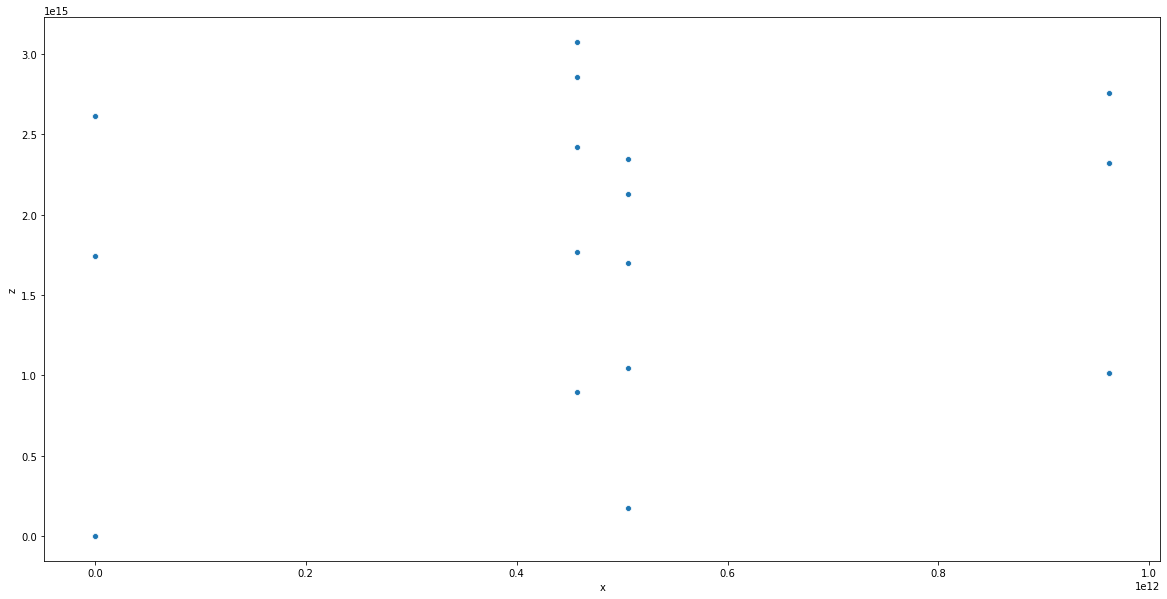

In [204]:
from math import cos,sin,tan,atan,degrees,radians, pi
import numpy as np
# from intagrate import *
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize)
# parametars
# E = 210*1000000000 # N/m^2 modul elastičnosti
rhoWater = 1025 # kg/ m^3
outerDiameter = 0.38094 # m outer diameter of pipe
innerDiameter = 0.1778 # m inner diameter of pipe
r_o = outerDiameter/2
r_i = innerDiameter/2

#lenght of one element(pipe)
l_pipe = 100
l =5

sea_depth = 1365 # m
#moment tromosti za cijev ovih dimenzija
I = pi/4*(r_o**4-r_i**4)
bending_stiffness = 176820
E = bending_stiffness / I

#gravity acc
g = 9.81 # m/s^2
#površina poprečnog  presjeka cijevi
A_pipe = ((outerDiameter**2 * pi) / 4) - ((innerDiameter**2 * pi) / 4)
#masa cijevi
m = A_pipe*7800
#masa cijevi u zraku po metru
weight_in_air = 161.34 # kg/m
#gustoća cijevi
density = weight_in_air/A_pipe
# volumen cijevi po metru
Volume_pipe = (outerDiameter)**2 *pi /4 # Volume per meter  m^3 /m
#uzgon cijevi po metru
buoyancy = rhoWater * Volume_pipe  # kg /m
#masa cijevi u vodi po metru
weight_in_water = weight_in_air - buoyancy  #kg /m

#težina cijevi
G_f = weight_in_water * g # N/m

# kontra sila koja je kontinuirana kako cijev nebi prelazila dno
# opruge kontinuriano djeluju na svaki čvor
spring_force = 436.631 #N/m
# G_f = G_f - spring_force

# prelazak iz XYZ u XZ
points = np.array([[0,0,0],[100,0,0]])
L = points[1][0]- points[0][0]
H = points[1][1]- points[0][1]
alfa = atan(H/L)  # Azimuth angle

# dobivanje točaka XYZ za kut zakreta alfa, konstantan y
print(f"Azimuth is {degrees(alfa)} deg")
t_m = np.array([[cos(alfa), sin(alfa),0],[-sin(alfa), cos(alfa), 0],[0,0,1]])
new_points = []
for vect in points:
  new_points.append(t_m.dot(vect))

#prelazak iz globalnog sustava XZ u lokalni xz
L1 = new_points[1][0] -new_points[0][0]
H1 = new_points[0][2]- new_points[1][2]
alfa1 = atan(H1/L1)



# # matrica transformacije za dobivanje lokalne matrice krutosti
# T_1 = np.array([[cos(alfa1), sin(alfa1), 0, 0, 0, 0], [-sin(alfa1), cos(alfa1), 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],
#                 [0, 0, 0, cos(alfa1), sin(alfa1), 0], [0, 0, 0, -sin(alfa1), cos(alfa1), 0], [0, 0, 0, 0, 0, 1]])

# matrix of stiffness, lokalna matrica krutosti
k_local = np.array([[(A_pipe* E / l), 0, 0, (-A_pipe*E/ l), 0, 0], [0, 12*(E*I)/l**3, -6*(E*I)/l**2, 0, -12*(E*I)/l**3, -6*(E*I)/l**2],
             [0, -6*(E*I)/l**2 , 4*(E*I)/l, 0, 6*(E*I)/l**2, 2*(E*I)/l], [(-A_pipe* E / l), 0, 0, (A_pipe*E/ l), 0, 0],
             [0, -12*(E*I)/l**3, 6*(E*I)/l**2, 0, 12*(E*I)/l**3, 6*(E*I)/l**2], [0, -6*(E*I)/l**2 , 2*(E*I)/l, 0, 6*(E*I)/l**2, 4*(E*I)/l]] )

# nova matrica transformacije, uklještenje okrenuto za 90 stupnjeva
alfa2 = pi/2
# matrica transformacije za dobivanje lokalne matrice krutosti
T = np.array([[cos(alfa1), sin(alfa1), 0, 0, 0, 0], [-sin(alfa1), cos(alfa1), 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],
                [0, 0, 0, cos(alfa2), sin(alfa2), 0], [0, 0, 0, -sin(alfa2), cos(alfa2), 0], [0, 0, 0, 0, 0, 1]])


# lokalna matrica krutosti u odnosu na globalnu
T_transpose = T.transpose()  # transpose matrix of transformation
k_global = np.matmul(T,k_local)


#proširivanje matrice krutosti na globalnu razinu za svaki konačni element, K predstavlja globalnu matricu krutosti svih elemenata.
elements = int(l_pipe/l)
K =np.zeros((elements*3 + 3,elements*3 + 3))
for x in range(elements):
    for y in range(6):
        count = 0
        for k in k_global[y]:
            K[y+3*x][count+ 3*x] += k
            count += 1


# prebacivanje kontinuiranog opterećenja u lokalni sustav
G_f_x = G_f* sin(alfa1)
G_f_z = -G_f* cos(alfa1)
print(G_f_x,G_f_z)
# Funkcije oblika za cjevovod

# N1 = quad(integrand_n1, f , x, args=l)
# N2 = quad(integrand_n2, f, x, args=l)
# N3 = quad(integrand_n3, f, x, args=l)
# N4 = quad(integrand_n1, f, x, args=l)
# N11 = quad(integrand_n11, f, x, args=l)
# N22= quad(integrand_n22, f, x, args=l)
# # N = np.array([[N11[0], 0], [0, N1[0]], [0, N2[0]], [N22[0], 0], [0, N3[0]], [0, N4[0]]])

# dobivanje sila u pojedinim čvorovima(lokalno) pa pretvaranje sila u globalni sustav.
R = np.zeros((elements*3 +3,1))
f = 0
x = l
for e in range(elements):
    N1 = quad(integrand_n1, f, x, args=l)
    N2 = quad(integrand_n2, f, x, args=l)
    N3 = quad(integrand_n3, f, x, args=l)
    N4 = quad(integrand_n1, f, x, args=l)
    N11 = quad(integrand_n11, f, x, args=l)
    N22 = quad(integrand_n22, f, x, args=l)
    N = np.array([[N11[0], 0], [0, N1[0]], [0, N2[0]], [N22[0], 0], [0, N3[0]], [0, N4[0]]])
    # kontinuirana opterećenja
    Q = np.array([[G_f_x], [G_f_z]])
    # konačne sile i momenti u lokalnom sustavu
    F_local = np.matmul(N, Q)
    # u lokalnom sustavu  u odnosu na globalni
    F_global = np.matmul(T,F_local)

    for y in range(6):
        R[y+ 3*e][0] += F_global[y][0]


# rubni uvjeti (vA_x = 0 , vA_z = 0, vB_x = 0, vB_z = 0, vB_y = 0)
#križamo redove i stupce globalne matrice krutosti
K =  np.delete(K,0, axis=0)
K =  np.delete(K,0, axis=0)
K =  np.delete(K,-1, axis=0)
K =  np.delete(K,-1, axis=0)
K =  np.delete(K,-1, axis=0)

K =  np.delete(K,0, axis=1)
K =  np.delete(K,0, axis=1)
K =  np.delete(K,-1, axis=1)
K =  np.delete(K,-1, axis=1)
K =  np.delete(K,-1, axis=1)

# analgono križamo redove matrice globalnih sila
R = np.delete(R,0,axis=0)
R = np.delete(R,0, axis=0)
R = np.delete(R,-1, axis=0)
R = np.delete(R,-1, axis=0)
R = np.delete(R,-1, axis=0)


# budući da je cilj u točki A želimo dobiti moment koji će iznositi nula postavljamo sami moment u 0
R[0][0]= 0   # postavljamo moment u nulu

# inverziramo matricu krutosti kako bi dobili pomake
K_inv = np.linalg.inv(K)


# # pomaci u svim čvorovima pomak x, z i kut zakreta oko osi y
v= np.matmul(K_inv, R)

# vračamo rubne uvjete u konačne pomake
v= np.insert(v, 0, 0, axis=0)
v= np.insert(v, 0, 0, axis=0)
v= np.append(v, [[0], [0], [0]],  axis=0)

# matrica transformacije za pomake
t_m_2 = np.array([[cos(alfa1), sin(alfa1)],[-sin(alfa1), cos(alfa1)]])
t_m_2_t = t_m_2.transpose()

x_x = [v[i] for i in range(0, len(v), 3)]
z_z = [v[i] for i in range(1, len(v), 3)]

point = np.zeros((2,1))
new_v = []
for x,z in zip(x_x,z_z):
    list_point_x = []
    list_point_z = []
    point[0] = x
    point[1] = z
    new_point = np.matmul(t_m_2_t, point)
    list_point_x.append(float(new_point[0]))
    list_point_z.append(float(new_point[1]))
    new_v.append(list_point_x)
    new_v.append(list_point_z)

v = np.asarray(new_v)

x_x = [v[i] for i in range(0, len(v), 2)]
z_z = [v[i] for i in range(1, len(v), 2)]

to_new_node = 0
for x,z in zip(x_x,z_z):
    x += 8.98 + to_new_node
    z += 44.644
    to_new_node += l

# vračanje točaka u globalni XZ sustav
x_z = []
point = np.zeros((2, 1))
for x,z in zip(x_x,z_z):
    list_point_x = []
    list_point_z = []
    point[0] = x
    point[1] = z
    new_point = np.matmul(t_m_2, point)
    list_point_x.append(float(new_point[0]))
    list_point_z.append(float(new_point[1]))
    x_z.append(list_point_x)
    x_z.append(list_point_z)

# koordinate u x_z osi savijene cijevi
# prvi član je x drugi z i tako dalje
x_z = np.asarray(x_z)

# print(x_z)

# crtanje krivulje u XZ osi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
x= [x_z[i] for i in range(0, len(x_z), 2)]
z= [x_z[i] for i in range(1, len(x_z), 2)]
df=pd.DataFrame(x)
df.columns=["x"]
df["z"]=pd.DataFrame(z)
plt.figure(figsize=(20,10))
sns.scatterplot(x="x", y="z", data=df)

plt.show()



